# Select Image Pairs for Users to Review

In [56]:
import pandas as pd
import numpy as np
import ast
import tqdm
import json

from matplotlib import pyplot as plt

In [ ]:
def model_proto_out_to_df(file_path):
    """
    Parse the nested dictionary structure into a pandas DataFrame.
    
    Args:
        data_dict (dict): The input nested dictionary structure
        
    Returns:
        pd.DataFrame: A flattened DataFrame representation of the data
    """
    # Prepare lists to collect all data
    all_records = []

    with open(file_path, 'r') as f:
        data_dict = json.load(f)
    
    # Iterate through the top-level reference IDs
    for ref_id, models_dict in data_dict.items():
        # Iterate through models (cos, l2)
        for model_type, img_dict in models_dict.items():
            # Iterate through image indices
            for img_idx, records in img_dict.items():
                # Iterate through each record for this image
                for record in records:
                    # Create a flattened record with all relevant information
                    flat_record = {
                        'ref_id': ref_id,
                        'activation_function': model_type,
                        'img_idx': img_idx
                    }
                    
                    # Add all fields from the record
                    flat_record.update(record)
                    
                    # Append to our collection
                    all_records.append(flat_record)
    
    # Convert to DataFrame
    df = pd.DataFrame(all_records)
    
    # Convert numeric columns to appropriate types
    numeric_cols = ['proto_rank', 'act_percentile', 'act_val']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col])

    return df.set_index(['ref_id'])

bounding_boxes = model_proto_out_to_df(os.environ['STUDY_MODEL_PROTO_OUT'])
bounding_boxes.head()

## Calculate Reference Patches

In [ ]:
def compute_iou_vectorized(boxes1, boxes2, eps=1e-6):
    """
    Vectorized IoU computation for two sets of boxes in format: [x1, y1, x2, y2].
    boxes1: shape (N, 4), boxes2: shape (M, 4)
    Returns: IoU matrix of shape (N, M).
    """
    try:
        x1 = np.maximum(boxes1[:, 0][:, None], boxes2[:, 0][None, :])
        y1 = np.maximum(boxes1[:, 1][:, None], boxes2[:, 1][None, :])
        x2 = np.minimum(boxes1[:, 2][:, None], boxes2[:, 2][None, :])
        y2 = np.minimum(boxes1[:, 3][:, None], boxes2[:, 3][None, :])

        inter_width = np.maximum(0, x2 - x1)
        inter_height = np.maximum(0, y2 - y1)
        intersection = inter_width * inter_height

        area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
        area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

        union = area1[:, None] + area2[None, :] - intersection
        iou = intersection / (union + eps)
    except Exception as e:
        print(f"Error: {e}")
        raise e
        
    return iou

def stack_bb(series):
    return np.stack(series.apply(np.array).values)

matrix_sizes = []
pairs_data = []
for ref_id, pair_df in tqdm.tqdm(bounding_boxes.reset_index().groupby('ref_id')):
    for img, df in pair_df.groupby('ref_path'):

        l2 = df[df['activation_function'] == 'l2']
        cos = df[df['activation_function'] == 'cos']

        if len(l2) == 0 or len(cos) == 0:
            matrix_sizes.append((img, 0))
            continue

        iou_matrix = compute_iou_vectorized(stack_bb(l2['ref_box']), stack_bb(cos['ref_box']))
        matrix_sizes.append((img, iou_matrix.shape[0]))

        l2_patches = l2['ref_box'].values
        cos_patches = cos['ref_box'].values

        for i, l2_patch in enumerate(l2_patches):
            for j, cos_patch in enumerate(cos_patches):
                iou_value = iou_matrix[i, j]
                if iou_value > 0.8:
                    pairs_data.append({
                        'ref_id': ref_id,
                        'ref_path': img,
                        'l2_proto_idx': l2.iloc[i]['proto_idx'],
                        'cos_proto_idx': cos.iloc[j]['proto_idx'],
                        'iou': iou_value
                    })

matrix_sizes_df = pd.DataFrame(matrix_sizes, columns=['image', 'matches'])
pairs_df = pd.DataFrame(pairs_data)
plt.hist(matrix_sizes_df['matches'], bins=20)
pairs_df

In [ ]:
pairs_df['cos_proto_idx'] = pairs_df['cos_proto_idx'].astype(str)
pairs_df['l2_proto_idx'] = pairs_df['l2_proto_idx'].astype(str)
pairs_df

<AxesSubplot: >

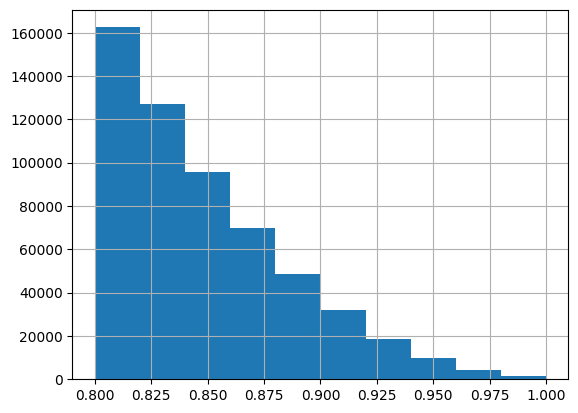

In [233]:
pairs_df['iou'].hist()

## Select Model Pairs

In [ ]:
pairs_df['cos_proto_idx'] = pairs_df['cos_proto_idx'].astype(str)
pairs_df['l2_proto_idx'] = pairs_df['l2_proto_idx'].astype(str)
pairs_df[['ref_id', 'cos_proto_idx', 'l2_proto_idx']]

In [ ]:
__bb = bounding_boxes.reset_index()

compiled_boxes = pairs_df
for act in ['cos', 'l2']:
    __df = __bb[__bb['activation_function'] == act]
    __df = __df.drop(columns=['activation_function'])

    compiled_boxes = compiled_boxes \
        .merge(__df, suffixes=('BAD', 'PROBLEM') if act == 'cos' else ('_cos', '_l2'), left_on=('ref_id', f'{act}_proto_idx', 'ref_path'), right_on=('ref_id', 'proto_idx', 'ref_path'))

compiled_boxes = compiled_boxes.drop(columns=['cos_proto_idx', 'l2_proto_idx'])
compiled_boxes

In [236]:
# all the images should match, but we can't enforce that except through the row id
(compiled_boxes['img_idx_cos'] == compiled_boxes['img_idx_l2']).value_counts()

True    569326
Name: count, dtype: int64

In [ ]:
compiled_boxes['img_idx'] = compiled_boxes['img_idx_cos']
compiled_boxes = compiled_boxes.drop(columns=['img_idx_cos', 'img_idx_l2'])
compiled_boxes.columns

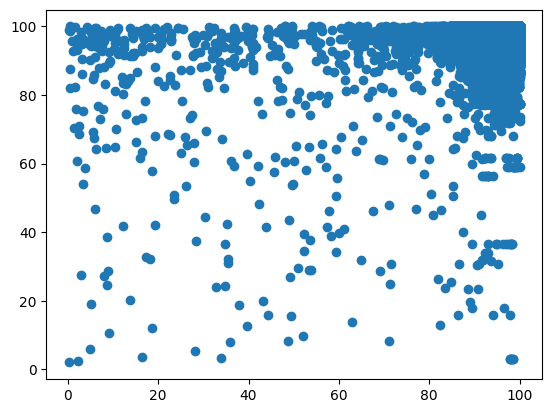

In [238]:
plt.scatter(compiled_boxes['act_percentile_cos'], compiled_boxes['act_percentile_l2'])

In [ ]:
def average_patch(box1, box2):
    avg_left_x = int((box1[0] + box2[0]) / 2)
    avg_upper_y = int((box1[1] + box2[1]) / 2)
    avg_right_x = int((box1[2] + box2[2]) / 2)
    avg_lower_y = int((box1[3] + box2[3]) / 2)
    final_ref_patch = [avg_left_x, avg_upper_y, avg_right_x, avg_lower_y]
    return final_ref_patch

compiled_boxes['ref_box_mean'] = compiled_boxes.apply(lambda row: average_patch(row['ref_box_l2'], row['ref_box_cos']), axis=1)
compiled_boxes[['ref_box_mean', 'ref_box_l2', 'ref_box_cos']]

In [240]:
id_names = compiled_boxes['ref_id'].str.split('_')
compiled_boxes['model_a'] = id_names.apply(lambda x: x[3])
compiled_boxes['model_b'] = id_names.apply(lambda x: x[7])
compiled_boxes[['model_a', 'model_b']].value_counts()

model_a         model_b       
dreamy-puppy    gentle-meadow     43896
tender-planet   neat-rocket       42998
tidy-parrot     mighty-whale      35766
spunky-flame    soft-mirror       29313
quirk-mirror    clever-balloon    22931
                                  ...  
jumpy-mount     chilly-island       197
brisk-spark     swift-jewel         151
zesty-vessel    bright-flame        149
thrifty-window  eager-field         142
quirk-zephyr    jolly-thunder       125
Name: count, Length: 65, dtype: int64

In [241]:
compiled_boxes['backbone'] = compiled_boxes['ref_id'].str.split('_').str[-1]
compiled_boxes['backbone'].value_counts()

backbone
densenet161                          327199
resnet50[pretraining=inaturalist]    222008
vgg19                                 20119
Name: count, dtype: int64

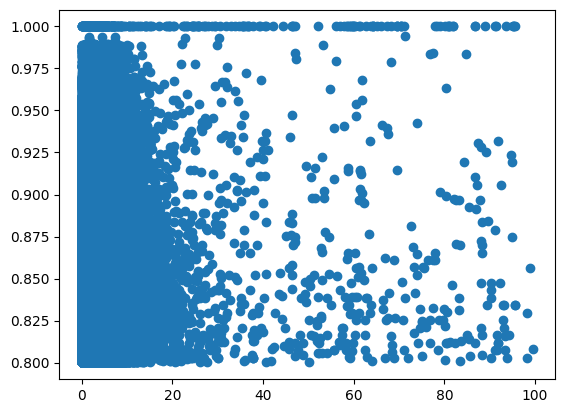

In [242]:
compiled_boxes['act_diff_per'] = abs(compiled_boxes['act_percentile_cos'] - compiled_boxes['act_percentile_l2'])

plt.scatter(compiled_boxes['act_diff_per'], compiled_boxes['iou'])

In [ ]:
groups = ['ref', 'cos', 'l2']
for g in groups:
    col = 'ref_path' if g == 'ref' else f'proto_path_{g}'
    compiled_boxes[f'class_{g}'] = compiled_boxes[col].str.split('/').apply(lambda x: x[7])

compiled_boxes[[f'class_{g}' for g in groups]]

In [244]:
compiled_boxes['class_cos_equals'] = compiled_boxes['class_cos'] == compiled_boxes['class_ref']
compiled_boxes['class_l2_equals'] = compiled_boxes['class_l2'] == compiled_boxes['class_ref']
compiled_boxes['class_both_equals'] = compiled_boxes['class_cos_equals'] & compiled_boxes['class_l2_equals']
compiled_boxes['class_both_not_equals'] = ~(compiled_boxes['class_cos_equals'] | compiled_boxes['class_l2_equals'])
compiled_boxes['both_classes_eq_or_not_eq'] = compiled_boxes['class_both_equals'] | compiled_boxes['class_both_not_equals']

compiled_boxes.groupby(['both_classes_eq_or_not_eq', 'class_cos_equals', 'class_l2_equals']).count()[['ref_id']]

ref_id
both_classes_eq_or_not_eq class_cos_equals class_l2_equals        
False                     False            True             118002
                          True             False             29733
True                      False            False            409434
                          True             True              12157

In [246]:
# eliminate cases where both prototypes are from same source image - too hard to distinguish
display((compiled_boxes['proto_path_cos'] == compiled_boxes['proto_path_l2']).value_counts())

no_match_cases = compiled_boxes[compiled_boxes['proto_path_cos'] != compiled_boxes['proto_path_l2']]
(no_match_cases['proto_path_cos'] == no_match_cases['proto_path_l2']).value_counts()

False    567823
True       1503
Name: count, dtype: int64

False    567823
Name: count, dtype: int64

In [247]:
(no_match_cases['act_diff_per'] < 10).value_counts()

act_diff_per
True     562466
False      5357
Name: count, dtype: int64

In [ ]:
similar_no_match_cases = no_match_cases[no_match_cases['both_classes_eq_or_not_eq'] == True]
similar_no_match_cases

In [252]:
TOTAL_SAMPLES = 54
per_backbone = TOTAL_SAMPLES // 3
per_backbone

18

In [325]:
# these are images where neither prototype is on the bird
# they were included in sampling originally, so now they're manually rejected
selected_samples_no_birds = [
    'row95_img_idx0_bouncy-plant_bouncy-plant_best_feisty-wildcat_feisty-wildcat_best_vgg19',
    'row96_img_idx0_brisk-spark_brisk-spark_best_swift-jewel_swift-jewel_best_vgg19',
    'row84_img_idx0_nimble-balloon_nimble-balloon_best_shiny-stream_shiny-stream_best_vgg19',
    'row80_img_idx0_zesty-vessel_zesty-vessel_best_bright-flame_bright-flame_best_vgg19',
    'row100_img_idx0_jumpy-mount_jumpy-mount_best_chilly-island_chilly-island_best_vgg19'
]
similar_no_match_cases = similar_no_match_cases[~similar_no_match_cases['ref_id'].isin(selected_samples_no_birds)]

In [327]:
import random
random.seed(0)

def select_stratified_samples(df, per_backbone):
    selected_indices = []
    # randomize the dataframe for sampling
    df = df.sample(frac=1)

    df['act_percentile_min'] = df[['act_percentile_cos', 'act_percentile_l2']].min(axis=1)
    df = df[df['act_percentile_min'] >= 90]
    df['percentile_bin'] = pd.cut(df['act_percentile_min'], bins=6, labels=False)

    df.groupby('percentile_bin').count()[['ref_id']].T.pipe(display)

    samples_by_backbone = {k: 0 for k in df['backbone'].unique()}
    
    last_samples = {}
    # For each backbone, keep selecting until we hit the target number
    while any(samples_by_backbone[k] < per_backbone for k in samples_by_backbone.keys()):
        # Get remaining samples needed for each backbone
        if last_samples == samples_by_backbone:
            print('could not fulfill criteria')
            break
        last_samples = samples_by_backbone.copy()

        remaining_samples = {
            k: per_backbone - samples_by_backbone[k] 
            for k in samples_by_backbone.keys()
        }
        
        # Filter to only backbones that still need samples
        active_backbones = [k for k, v in remaining_samples.items() if v > 0]
        
        # Get available rows (not already selected)
        available_df = df[~df.index.isin(selected_indices)].copy()
        if len(available_df) == 0:
            break
            
        for backbone in active_backbones:
            if samples_by_backbone[backbone] >= per_backbone:
                continue
                
            backbone_df = available_df[available_df['backbone'] == backbone]
            if len(backbone_df) == 0:
                continue

            # Get counts of already selected samples for this backbone
            selected_backbone_df = df.loc[selected_indices]
            selected_backbone_df = selected_backbone_df[
                selected_backbone_df['backbone'] == backbone
            ]

            backbone_df = backbone_df[~backbone_df['ref_path'].isin(selected_backbone_df.ref_path)]
            
            for bin_num in range(6):
                bin_len = len(selected_backbone_df[selected_backbone_df['percentile_bin'] == bin_num])
                if bin_len < 2:
                    backbone_df = backbone_df[backbone_df['percentile_bin'] == bin_num]
                    break

                elif bin_len > 4:
                    backbone_df = backbone_df[backbone_df['percentile_bin'] != bin_num]
                    
            if selected_backbone_df['class_both_equals'].value_counts().get(True, 0) == per_backbone//2:
                backbone_df = backbone_df[backbone_df['class_both_not_equals']]
            elif selected_backbone_df['class_both_not_equals'].value_counts().get(True, 0) == per_backbone//2:
                backbone_df = backbone_df[backbone_df['class_both_equals']]
            
            model_a_counts = selected_backbone_df['model_a'].value_counts()
            model_b_counts = selected_backbone_df['model_b'].value_counts()
            class_counts = selected_backbone_df['class_ref'].value_counts()
            
            # Find underrepresented models and classes
            all_a_models = set(backbone_df['model_a'].unique())
            all_b_models = set(backbone_df['model_b'].unique())
            all_classes = set(backbone_df['class_ref'].unique())
            
            missing_a_models = all_a_models - set(model_a_counts.index)
            missing_b_models = all_b_models - set(model_b_counts.index)
            missing_classes = all_classes - set(class_counts.index)
            
            # Prioritize rows with missing models and classes
            candidates = backbone_df
            if (len(missing_a_models) > 0 or len(missing_b_models) > 0):
                unused_as = candidates['model_a'].isin(missing_a_models)
                unused_bs = candidates['model_b'].isin(missing_b_models)

                if (unused_as & unused_bs).any():
                    candidates = candidates[unused_as & unused_bs]
                elif (unused_as | unused_bs).any():
                    candidates = candidates[unused_as | unused_bs]
            
            if sum(candidates['class_ref'].isin(missing_classes)) > 0:
                candidates = candidates[candidates['class_ref'].isin(missing_classes)]

            best_row = candidates.sort_values('act_diff_per', ascending=True).head(1)
            if not best_row.empty:
                selected_indices.append(best_row.index[0])
                samples_by_backbone[backbone] += 1
    
    return df.loc[selected_indices]

selected_samples = select_stratified_samples(similar_no_match_cases, per_backbone)

selected_samples.groupby('backbone').count()[['ref_path']]

percentile_bin,0,1,2,3,4,5
ref_id,21551,51752,85103,105759,97137,47270


,ref_path
backbone,
densenet161,18
resnet50[pretraining=inaturalist],18
vgg19,18


array([[<AxesSubplot: title={'center': 'act_diff_per'}>,
        <AxesSubplot: title={'center': 'act_percentile_cos'}>],
       [<AxesSubplot: title={'center': 'act_percentile_l2'}>,
        <AxesSubplot: >]], dtype=object)

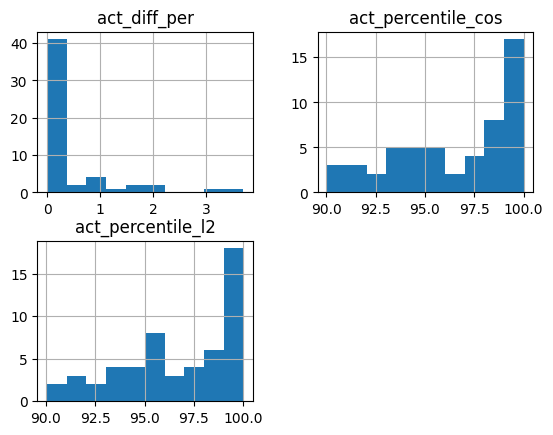

In [328]:
selected_samples[['act_diff_per', 'act_percentile_cos', 'act_percentile_l2']].hist()

In [329]:
selected_samples.groupby(['model_a', 'model_b']).count()[['ref_path']].sort_values('ref_path', ascending=False)

,,ref_path
model_a,model_b,
bubbly-whale,silent-field,2
happy-chair,swift-sapphire,2
breezy-ribbon,true-season,1
steady-forest,sober-jewel,1
quirky-field,dainty-pebble,1
shiny-vessel,rapid-sapphire,1
silent-sapphire,0.843,1
smooth-jewel,shy-snow,1
snappy-shadow,silent-plume,1


In [330]:
selected_samples.groupby(['backbone', 'class_cos_equals', 'class_l2_equals']).count()[['ref_path']]

ref_path
backbone                          class_cos_equals class_l2_equals          
densenet161                       False            False                   9
                                  True             True                    9
resnet50[pretraining=inaturalist] False            False                   9
                                  True             True                    9
vgg19                             False            False                   9
                                  True             True                    9

In [331]:
selected_samples.groupby(['class_ref']).count()[['ref_path']].sort_values('ref_path', ascending=False)

,ref_path
class_ref,
055.Evening_Grosbeak,2
179.Tennessee_Warbler,2
066.Western_Gull,2
001.Black_footed_Albatross,1
129.Song_Sparrow,1
131.Vesper_Sparrow,1
137.Cliff_Swallow,1
142.Black_Tern,1
143.Caspian_Tern,1


In [332]:
selected_samples[['ref_path', 'proto_path_cos', 'proto_path_l2']].nunique()

ref_path          52
proto_path_cos    54
proto_path_l2     54
dtype: int64

In [333]:
selected_samples.sample(frac=1.0).to_csv('user_study/user-samples.csv')

```{bash}
export STUDY_CSV_TRIPLET_PATH=user_study/user-samples.csv
export STUDY_OUTPUT_DIR=$STUDY_DIR/user-samples
python user_study/process_images.py
```

## Generate "Bad" Pairs for Attention Checks
Note that these are manually reviewed to make sure they are completely unambiguous.

In [ ]:
leftover_samples = compiled_boxes[~compiled_boxes.index.isin(selected_samples.index)].copy()
leftover_samples

In [ ]:
leftover_samples.columns

In [ ]:
leftover_samples['per_diff'] = abs(leftover_samples['option_l2_act_percs'] - leftover_samples['option_cos_act_percs'])
# find examples where one class matches and the other doesn't
diff_class_samples = leftover_samples[(leftover_samples['option_cos_class'] != leftover_samples['option_l2_class']) & (leftover_samples['class_cos_equals'] | leftover_samples['class_l2_equals'])]
diff_class_samples = diff_class_samples.sort_values('per_diff', ascending=False)
diff_class_samples

In [ ]:
# manually inspect the results
diff_class_samples.head(100).to_csv('user_study/attention-samples.csv')

```{bash}
export STUDY_CSV_TRIPLET_PATH=user_study/attention-samples.csv
export STUDY_OUTPUT_DIR=$STUDY_DIR/attention-samples
python user_study/process_images.py
```